In [4]:
import numpy as np
from logger import H5Interface
import matplotlib.pyplot as plt
#import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial
%matplotlib inline

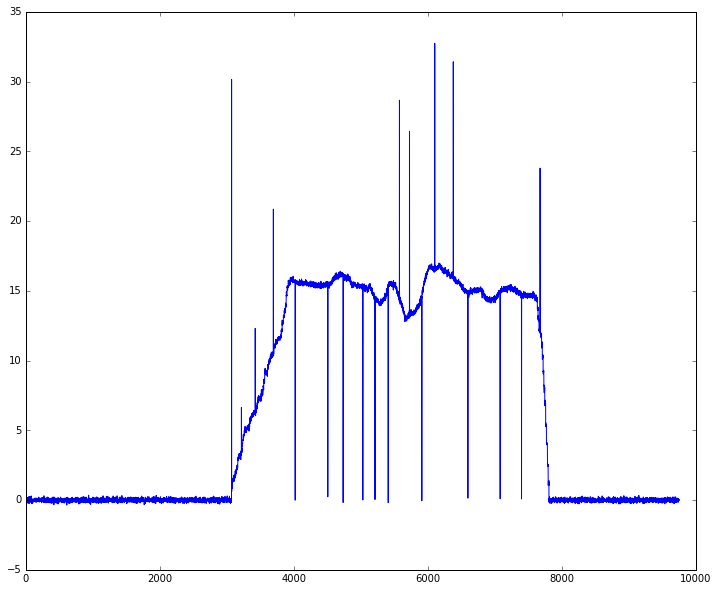

In [6]:
h = H5Interface()
data = h.get_data('trajectory_15', 'raw_data')
data = data['w_raw'][2,:]
fig = plt.figure(figsize=(12,10))
plt.plot(data)
plt.show()

In [7]:
def find_constraint_regions(data, window_size=100, look_ahead=3, mu_thresh=0.005):
    candidate_window = None
    in_constraint_region = False
    idx_from_candidate = 0
    start_windows = []
    stop_windows = []
    constraint_regions = []
    for i in range(int(len(data) / float(window_size))):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        current_window_data = data[start_idx:end_idx]
        # determine if still searching for boundary of constraint region (either start or end)
        if candidate_window is None:
            if in_constraint_region: 
                # see if current window could mark end of constraint region
                if np.absolute(np.mean(current_window_data)) <= mu_thresh and len(stop_windows) < len(start_windows):
                    candidate_window = (start_idx, end_idx)
                    idx_from_candidate = 1
            else:
                # see if current window could mark start of constraint region
                if np.absolute(np.mean(current_window_data)) > mu_thresh and len(start_windows) == len(stop_windows):
                    candidate_window = (start_idx, end_idx)
                    idx_from_candidate = 1
        # otherwise, a candidate is selected, need to do look ahead to see if it's a stable state
        else:
            if idx_from_candidate == look_ahead:
                if in_constraint_region: 
                    # check if current window still satisfies conditions for ending constraint region
                    if np.absolute(np.mean(current_window_data)) <= mu_thresh:
                        # candidate is valid terminating window
                        stop_windows.append(candidate_window)
                        candidate_window = None
                        idx_from_candidate = 0
                        in_constraint_region = False
                else:
                    # check if current window still satisfies conditions for starting constraint region
                    if np.absolute(np.mean(current_window_data)) > mu_thresh:
                        start_windows.append(candidate_window)
                        candidate_window = None
                        idx_from_candidate = 0
                        in_constraint_region = True
            else:
                if in_constraint_region:
                    # check if current window violates conditions for ending constraint region
                    if np.absolute(np.mean(current_window_data)) > mu_thresh:
                        # candidate is rejected
                        candidate_window = None
                        idx_from_candidate = 0
                    else:
                        # continue look ahead procedure
                        idx_from_candidate += 1
                else:
                    # check if current window violates conditions for starting constraint region
                    if np.absolute(np.mean(current_window_data)) <= mu_thresh:
                        # candidate is rejected
                        candidate_window = None
                        idx_from_candidate = 0
                    else:
                        # continue look ahead procedure
                        idx_from_candidate += 1
    
    print "START WINS", start_windows
    print "STOP WINS", stop_windows
    
    # find start points
    start_idxs = []
    for start_idx, end_idx in start_windows:
        for i in range(start_idx, end_idx):
            if abs(data[i]) > mu_thresh:
                start_idxs.append(i)
                break
                
    # find end points
    end_idxs = []
    for start_idx, end_idx in stop_windows:
        for i in range(start_idx, end_idx):
            if abs(data[i]) <= mu_thresh:
                end_idxs.append(i)
                break
                
    print "START IDXS", start_idxs
    print "END IDXS", end_idxs
                
    # resolve all constraint regions
    constraint_regions = zip(start_idxs, end_idxs)
    return constraint_regions

# TODO need to apply this function to multiple dimensions, and then resolve the regions so that
# overlapping regions are accounted for. 

In [8]:
crs = find_constraint_regions(data, window_size=50)
print crs

START WINS [(100, 150), (1900, 1950), (8200, 8250)]
STOP WINS [(1450, 1500), (7900, 7950)]
START IDXS [100, 1900, 8200]
END IDXS [1452, 7930]
[(100, 1452), (1900, 7930)]


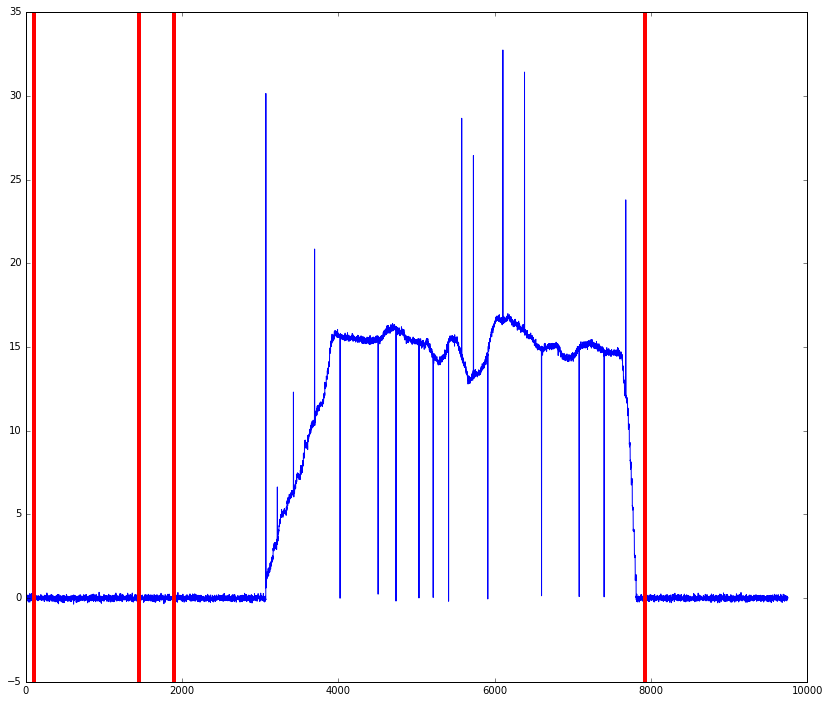

In [9]:
fig = plt.figure(figsize=(14,12))
plt.plot(data)
for cr in crs:
    plt.axvline(x=cr[0], color='r', lw=4.0)
    plt.axvline(x=cr[1], color='r', lw=4.0)
plt.show()

In [ ]:
Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=int(0.5*(len(data)+1))), offcd.gaussian_obs_log_likelihood, truncate=-20)

In [ ]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))

In [ ]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))